In [9]:
# importing dependancies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os

import re

from time import time

print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.18.0


[nltk_data] Downloading package stopwords to
[nltk_data]     /users/eleves-b/2022/axel.delaval/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Concatenation

In [10]:
def concat_tweets(df, MAX_SUBGROUP=150, event_type=True):
    """
    For each group of tweets with the same ID/MatchID/PeriodID/EventType,
    We create `MAX_SUBGROUP` subgroups of tweets by concatenating them.
    Therefore if `MAX_SUBGROUP` = 1, we have 1 tweet per ID/MatchID/PeriodID/EventType
    If `MAX_SUBGROUP` = +inf, we have all the tweets in different subgroups.
    """

    ### Grouping tweets who have same timestamp by concatenating them
    # Create an array of random integers in {0, ..., MAX_SUBGROUP} of size len(df_train)
    df["random_id"] = np.random.randint(0, MAX_SUBGROUP, len(df))
    if event_type:
        df_bis = df.groupby(['ID', "MatchID", "PeriodID", "EventType", "random_id"])['Tweet'].apply(lambda x: ' '.join(x)).reset_index().drop(columns='random_id')
    else:
        df_bis = df.groupby(['ID', "MatchID", "PeriodID", "random_id"])['Tweet'].apply(lambda x: ' '.join(x)).reset_index().drop(columns='random_id')
    df_bis = df_bis.sample(frac=1).reset_index(drop=True)
    return df_bis

# Embedding

In [11]:
def fit_tfidf_embedding(train_tweets, max_features=2000, ngram_range=(1,1), max_df=0.7, min_df=2, sublinear_tf=False):
    """
    Fit a TF-IDF vectorizer on the training tweets.
    Returns the fitted vectorizer.
    """
    vectorizer = TfidfVectorizer(max_features=max_features,
                                 max_df=max_df,
                                 ngram_range=ngram_range,
                                 min_df=min_df,
                                 sublinear_tf=sublinear_tf)
    vectorizer.fit(train_tweets)
    return vectorizer

def tfidf_embedding(tweets, vectorizer):
    """
    Transform tweets into TF-IDF features using a fitted vectorizer.
    """
    return vectorizer.transform(tweets).toarray()

# Loading

In [12]:
df_train = pd.read_csv("df_train_withoutstemming.csv")
df_eval = pd.read_csv("df_eval_withoutstemming.csv")

# str the 'Tweet' column
df_train['Tweet'] = df_train['Tweet'].astype(str)
df_eval['Tweet'] = df_eval['Tweet'].astype(str)
print(f'The shape of the training data is: {df_train.shape}')
print(f'The shape of the evaluation data is: {df_eval.shape}')

# Filter :
df_train = df_train[df_train["Tweet"].notnull()]  # Remove null values
df_train = df_train[df_train["Tweet"].str.strip() != ""]  # Remove empty strings
df_eval = df_eval[df_eval["Tweet"].notnull()]  # Remove null values
df_eval = df_eval[df_eval["Tweet"].str.strip() != ""]  # Remove empty strings

# # Remove any dupplicates
df_train = df_train.drop_duplicates()
df_eval = df_eval.drop_duplicates()
print(f'The shape of the training data after removing duplicates is: {df_train.shape}')
print(f'The shape of the evaluation data after removing duplicates is: {df_eval.shape}')

The shape of the training data is: (5056050, 6)
The shape of the evaluation data is: (1072928, 5)
The shape of the training data after removing duplicates is: (4518486, 6)
The shape of the evaluation data after removing duplicates is: (963395, 5)


In [13]:
Group_train = 100
Group_eval = 100

# Grouping
print("Grouping tweets...")

df_train_bis = concat_tweets(df_train, MAX_SUBGROUP=Group_train, event_type=True)
df_eval_bis = concat_tweets(df_eval, MAX_SUBGROUP=Group_eval, event_type=False)

print(f"The shape of the training data after grouping is: {df_train_bis.shape}")
print(f"The shape of the evaluation data after grouping is: {df_eval_bis.shape}")

print(f'The max number of words in a tweet is: {df_train_bis["Tweet"].apply(lambda x: len(x.split())).max()}')
print(f'The max number of words in a tweet is: {df_eval_bis["Tweet"].apply(lambda x: len(x.split())).max()}')

Grouping tweets...
The shape of the training data after grouping is: (210752, 5)
The shape of the evaluation data after grouping is: (50218, 4)
The max number of words in a tweet is: 606
The max number of words in a tweet is: 516


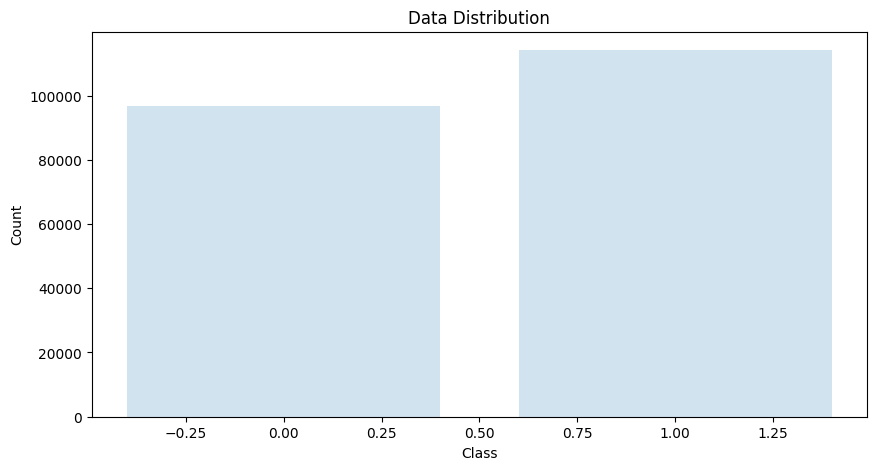

In [14]:
val_count_train = df_train_bis['EventType'].value_counts()

plt.figure(figsize=(10,5))
plt.bar(val_count_train.index, val_count_train.values, label='Training Data', alpha=0.2)
plt.title("Data Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [15]:
# Shuffle the rows

df_train_bis = df_train_bis.sample(frac=1).reset_index(drop=True)
df_eval_bis = df_eval_bis.sample(frac=1).reset_index(drop=True)

print('Data shuffled')

Data shuffled


# Embedding

In [16]:
train, test = train_test_split(df_train_bis, test_size=0.2, random_state=42)

In [17]:
np.max([len(tweet.split()) for tweet in train['Tweet']])

597

In [18]:
MAX_NB_WORDS = 2000
MAX_SEQUENCE_LENGTH = 613

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['Tweet'])

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 234685


In [21]:
from keras_preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train.Tweet), maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test.Tweet), maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (168601, 613)
Testing X Shape: (42151, 613)


In [22]:
labels = train.EventType.unique().tolist()
print(labels)

[0, 1]


In [23]:
encoder = LabelEncoder()
encoder.fit(train.EventType.to_list())

y_train = encoder.transform(train.EventType.to_list())
y_test = encoder.transform(test.EventType.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

y_train shape: (168601, 1)
y_test shape: (42151, 1)


In [24]:
GLOVE_EMB = 'glove.twitter.27B.200d.txt'
EMBEDDING_DIM = 200
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10

In [25]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 369269 word vectors.


In [26]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [27]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

/users/eleves-b/2022/axel.delaval/miniconda3/envs/inf554bis/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
W0000 00:00:1733932136.739364  472230 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# Training

In [28]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [29]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [40]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy', metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.001,
                                     patience = 1,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [41]:
print("Training on GPU...") if tf.config.list_physical_devices('GPU') else print("Training on CPU...")

Training on CPU...


In [42]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 355s 2s/step - accuracy: 0.6772 - loss: 0.5921 - val_accuracy: 0.6964 - val_loss: 0.5685 - learning_rate: 0.0010
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.6766 - loss: 0.5909 - val_accuracy: 0.6961 - val_loss: 0.5681 - learning_rate: 0.0010
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.6775 - loss: 0.5891 - val_accuracy: 0.6942 - val_loss: 0.5673 - learning_rate: 0.0010
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.6893 - loss: 0.5785 - val_accuracy: 0.7047 - val_loss: 0.5600 - learning_rate: 0.0010
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.6938 - loss: 0.5720 - val_accuracy: 0.7058 - val_loss: 0.5576 - learning_rate: 0.0010
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.6941 - loss: 0.5710 - val_accuracy: 0.7097 - val_loss: 0.5544 - learning_rate: 0.0010
Epoch 7/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.7020 - loss: 0.

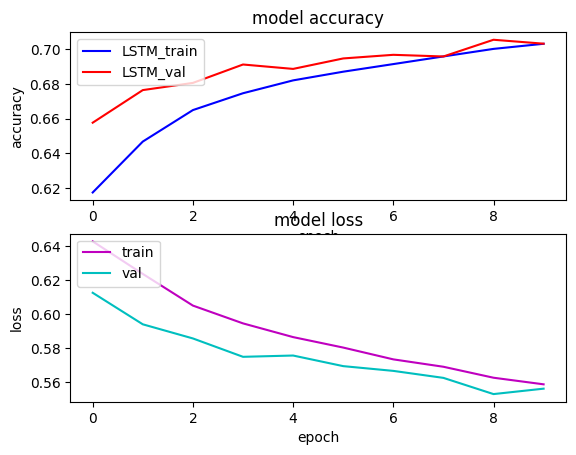

In [ ]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')